In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing, ExponentialSmoothing 
import warnings
warnings.filterwarnings("ignore") 

In [2]:
air=pd.read_excel("/Airlines_Data.xlsx",header=0,parse_dates=True)
air.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [3]:
air.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


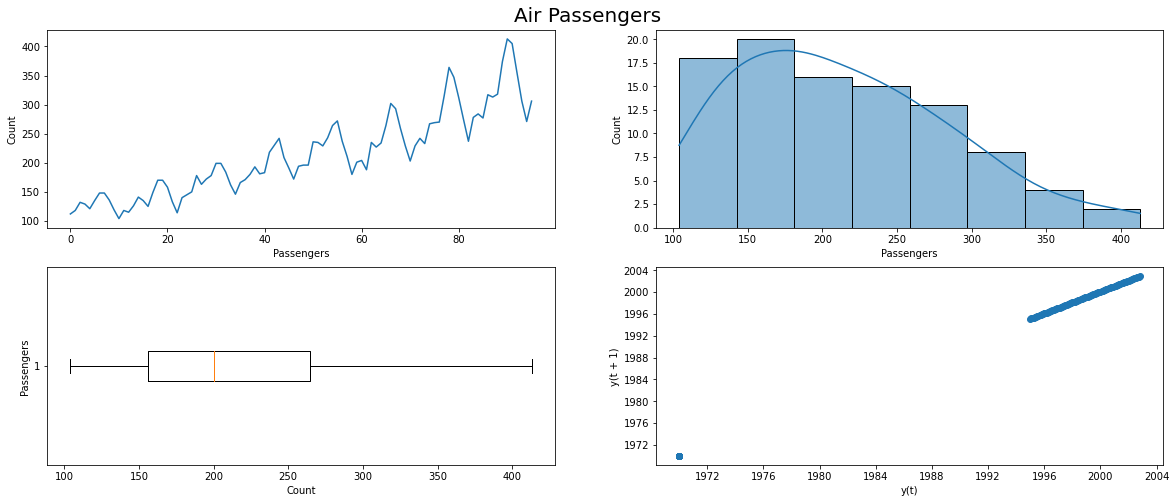

In [4]:
fig = plt.figure(figsize=(20,8))
plt.suptitle("Air Passengers", size=20, y=.92) 

plt.subplot(2,2,1)
air.Passengers.plot()
plt.xlabel("Passengers")
plt.ylabel("Count")

plt.subplot(2,2,2)
sns.histplot(x="Passengers",data=air,kde=True)

plt.subplot(2,2,3)
plt.boxplot(air["Passengers"],vert = False)
plt.xlabel("Count")
plt.ylabel("Passengers")

plt.subplot(2,2,4)
lag_plot(air)
plt.show();

*The Line Plot shows upward linear trend with Multiplicative seasonality.                                   
The Histogram is Positive Skew with a tapering tail towards right.                      
The Box Plot also shows a vast distance between the Whisker and Upper-Quartile.                    
The Lag Plot shows a Linear Relationship between the y(t) & y(t+1).*

In [5]:
#create column of strings from date given
air["Date"] = pd.to_datetime(air.Month,format="%b-%y")
air["month"] = air.Date.dt.strftime("%b") 
air["year"] = air.Date.dt.strftime("%Y") 
air.head()

,Month,Passengers,Date,month,year
0,1995-01-01,112,1995-01-01,Jan,1995
1,1995-02-01,118,1995-02-01,Feb,1995
2,1995-03-01,132,1995-03-01,Mar,1995
3,1995-04-01,129,1995-04-01,Apr,1995
4,1995-05-01,121,1995-05-01,May,1995


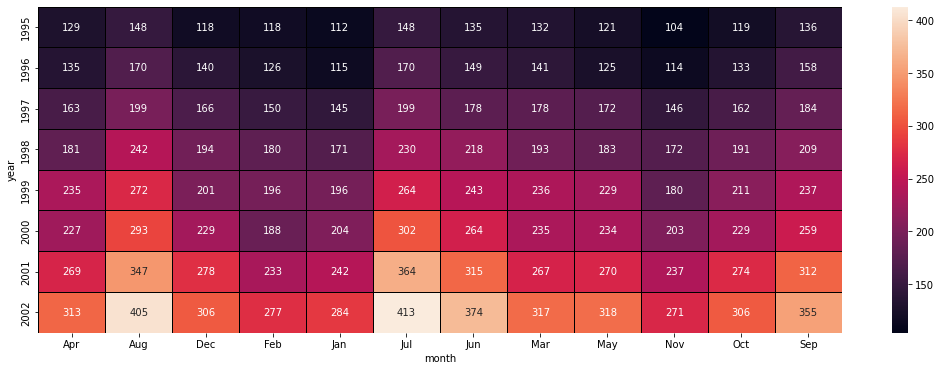

In [6]:
#Heatmap of average passengers month and year wise
plt.figure(figsize=(18,6))
heatmap_y_month = pd.pivot_table(data=air,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g",linewidths=.5,linecolor="black"); 

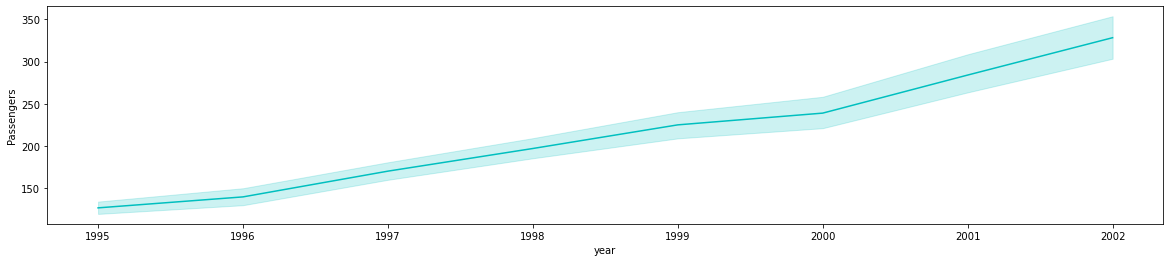

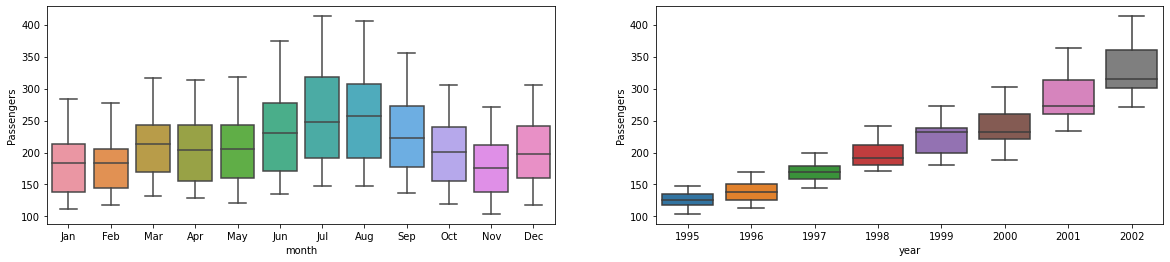

In [7]:
plt.figure(figsize=(20,4))
sns.lineplot(x="year",y="Passengers",data=air,color="c")

plt.figure(figsize=(20,4))
plt.subplot(121)
sns.boxplot(x="month",y="Passengers",data=air)
plt.subplot(122)
sns.boxplot(x="year",y="Passengers",data=air);

*It can be seen that Air Passengers are increasing year by year*                
**Data Preprocessing**

In [8]:
month_dummies = pd.DataFrame(pd.get_dummies(air["month"]))
air1 = pd.concat([air.iloc[:,1:],month_dummies],axis=1)
air1["t"] = np.arange(1,97)
air1["t_square"] = air1["t"]**2
air1["log"] = np.log(air1.Passengers)
air1.head()

,Passengers,Date,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_square,log
0,112,1995-01-01,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,118,1995-02-01,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,132,1995-03-01,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,129,1995-04-01,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,121,1995-05-01,May,1995,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


In [9]:
#Splitting data
Train = air1.head(70)
Test = air1.tail(26)

**Testing various model with accuracy**

## Model-Based Methods

In [10]:
#Linear Model
linear_model = smf.ols("Passengers~t",data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test["t"])))
rmse_linear = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_linear))**2))

In [11]:
#Exponential
Exp = smf.ols("log~t",data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test["t"])))
rmse_Exp = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(np.exp(pred_Exp)))**2))

In [12]:
#Quadratic 
Quad = smf.ols("Passengers~t+t_square",data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_Quad))**2))

In [13]:
#Additive seasonality 
add_sea = smf.ols("Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov",data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov"]]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_add_sea))**2))

In [14]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols("Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov",data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov",
                                                         "t","t_square"]]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_add_sea_quad))**2))

In [15]:
#Multiplicative Seasonality
Mul_sea = smf.ols("log~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov",data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(np.exp(pred_Mult_sea)))**2))

In [16]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols("log~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov",data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(np.exp(pred_Mult_add_sea)))**2))

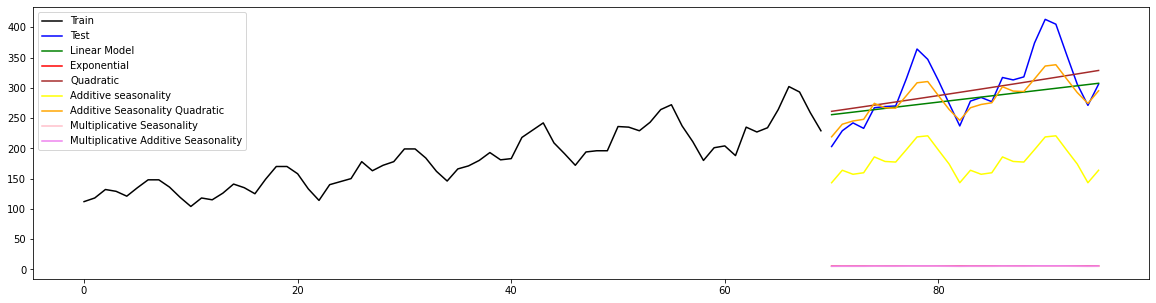

In [17]:
plt.figure(figsize=(20,5))
plt.plot(Train.index, Train["Passengers"], label="Train",color="black")
plt.plot(Test.index, Test["Passengers"], label="Test",color="blue")
plt.plot(pred_linear.index, pred_linear, label="Linear Model",color="green")
plt.plot(pred_Exp.index, pred_Exp, label="Exponential",color="red")
plt.plot(pred_Quad.index,pred_Quad,label="Quadratic",color="brown")
plt.plot(pred_add_sea.index,pred_add_sea,label="Additive seasonality",color="yellow")
plt.plot(pred_add_sea_quad.index,pred_add_sea_quad,label="Additive Seasonality Quadratic",color="orange")
plt.plot(pred_Mult_sea.index,pred_Mult_sea,label="Multiplicative Seasonality",color="pink")
plt.plot(pred_Mult_add_sea.index,pred_Mult_add_sea,label="Multiplicative Additive Seasonality",color="violet")
plt.legend(loc='best');

In [18]:
#Compare the results 
data={"Model_Based":pd.Series(["Linear","Exponential","Quadratic","Additive seasonality","Additive Seasonality Quadratic",
                         "Multiplicative Seasonality","Multiplicative Additive Seasonality"]),
      "RMSE Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
m_table_rmse=pd.DataFrame(data,index=None)
m_table_rmse.sort_values(['RMSE Values'])

,Model_Based,RMSE Values
6,Multiplicative Additive Seasonality,11.724791
4,Additive Seasonality Quadratic,30.393043
1,Exponential,43.478471
2,Quadratic,43.898145
0,Linear,48.309856
3,Additive seasonality,124.975700
5,Multiplicative Seasonality,129.629145


*Multiplicative Additive Seasonality with the lowest RMSE Value of 11.724791 is preferable*
## Data-Driven Models                     

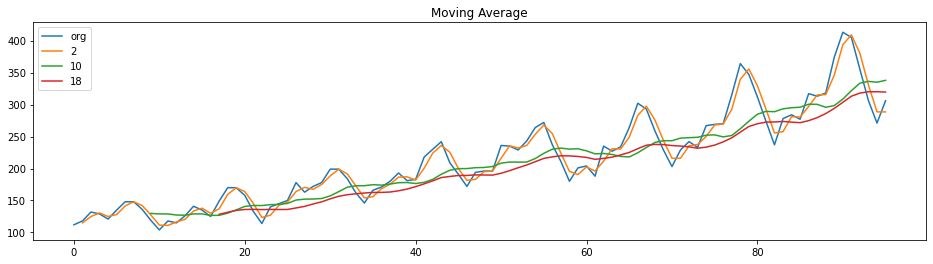

In [19]:
plt.figure(figsize=(16,4))
air1.Passengers.plot(label="org")
for i in range(2,24,8):  # for range 2-24 with intervals of 8
    air1["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc="best")
plt.title("Moving Average");

**Time series decomposition plot**

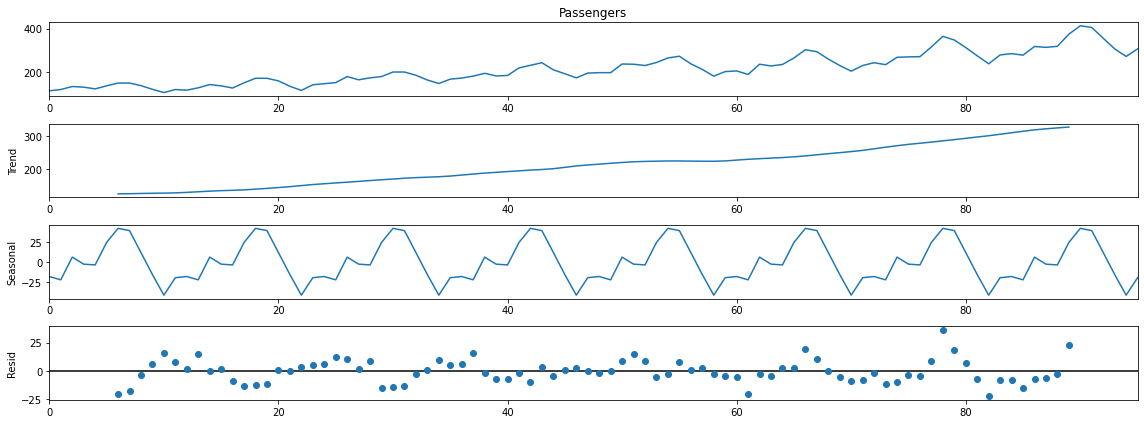

In [20]:
decompose_ts_add = seasonal_decompose(air.Passengers,period=12)
fig=decompose_ts_add.plot()
fig.set_size_inches((16, 6))
fig.tight_layout()
plt.show();

**ACF plots and PACF plots**

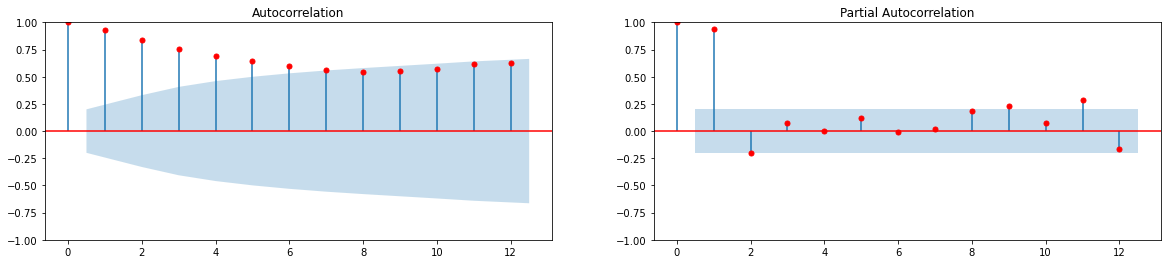

In [21]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((20, 4))
tsa_plots.plot_acf(air.Passengers,lags=12,color="red", ax=ax[0])
tsa_plots.plot_pacf(air.Passengers,lags=12,color="red", ax=ax[1]);

*Starting few points seems to be statistically significant*

In [22]:
#Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [23]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array((pred_ses)))**2))
mape_ses = MAPE(pred_ses,Test.Passengers) 

In [24]:
#Holt method
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array((pred_hw)))**2))
mape_hw = MAPE(pred_hw,Test.Passengers) 

In [25]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() 
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_aa = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array((pred_hwe_add_add)))**2))
mape_hwe_aa = MAPE(pred_hwe_add_add,Test.Passengers) 

In [26]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_ma = np.sqrt(np.mean((np.array(Test["Passengers"])-np.array((pred_hwe_mul_add)))**2))
mape_hwe_ma = MAPE(pred_hwe_mul_add,Test.Passengers)

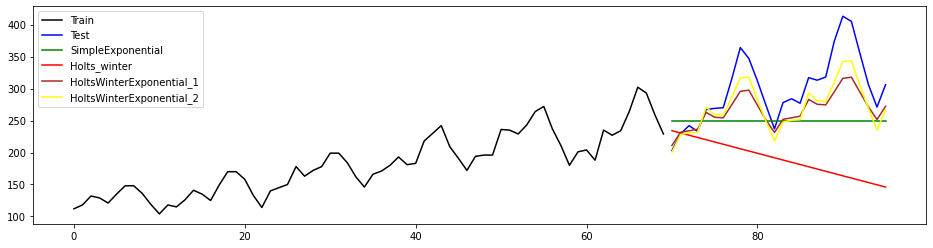

In [27]:
plt.figure(figsize=(16,4))
plt.plot(Train.index, Train["Passengers"], label="Train",color="black")
plt.plot(Test.index, Test["Passengers"], label="Test",color="blue")
plt.plot(pred_ses.index, pred_ses, label="SimpleExponential",color="green")
plt.plot(pred_hw.index, pred_hw, label="Holts_winter",color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc="best");

In [28]:
#Compare the results 
data={"Data_Driven":pd.Series(["Simple Exponential Method","Holt method","Winter with additive seasonality and trend",
                              "Winter with multiplicative seasonality and additive trend"]),
      "RMSE Values":pd.Series([rmse_ses,rmse_hw,rmse_hwe_aa,rmse_hwe_ma]),
     "MAPE Values":pd.Series([mape_ses,mape_hw,mape_hwe_aa,mape_hwe_ma])}
dd_table_rmse=pd.DataFrame(data,index=None)
dd_table_rmse.sort_values(["RMSE Values"])

,Data_Driven,RMSE Values,MAPE Values
3,Winter with multiplicative seasonality and add...,34.849070,9.102314
2,Winter with additive seasonality and trend,42.759252,10.305970
0,Simple Exponential Method,72.313128,17.662700
1,Holt method,130.566509,34.726305


*Holts winter exponential smoothing with multiplicative seasonality and additive trend with the lowest RMSE Value of 34.849070 is preferable*

## ARIMA Models

In [29]:
# separate out a validation dataset
air=pd.read_excel("/Airlines_Data.xlsx",
                  header=0,index_col=0,parse_dates=True)
split_point = len(air) - 26
dataset, validation = air[0:split_point], air[split_point:]
dataset.to_csv("dataset.csv", header=False)
validation.to_csv("validation.csv", header=False)

# evaluate a persistence model
train =pd.read_csv("dataset.csv", header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = train.values
X = X.astype("float32")
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [30]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    
# observation
    obs = test[i]
    history.append(obs)
    
# report performance
rmse_arima = sqrt(mean_squared_error(test, predictions))
print("RMSE: %.2f" % rmse_arima)

RMSE: 22.24


In [31]:
model = sm.tsa.arima.ARIMA(air.values, order=(2,1,2))
model_fit = model.fit()

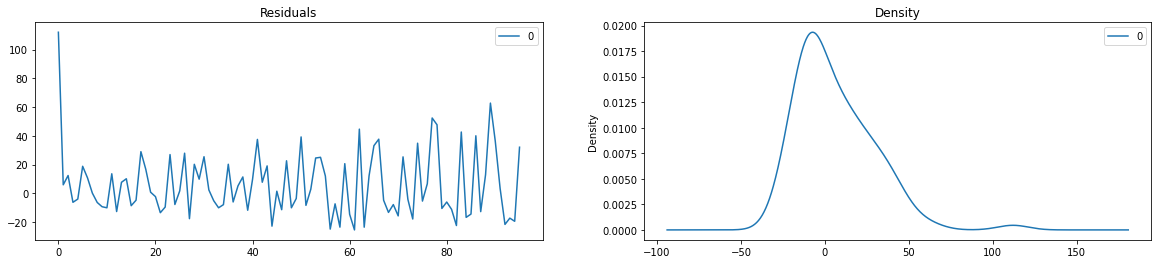

In [32]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0],figsize=(20,4))
residuals.plot(kind="kde", title="Density", ax=ax[1],figsize=(20,4));

*Here there is residual and Density plot*

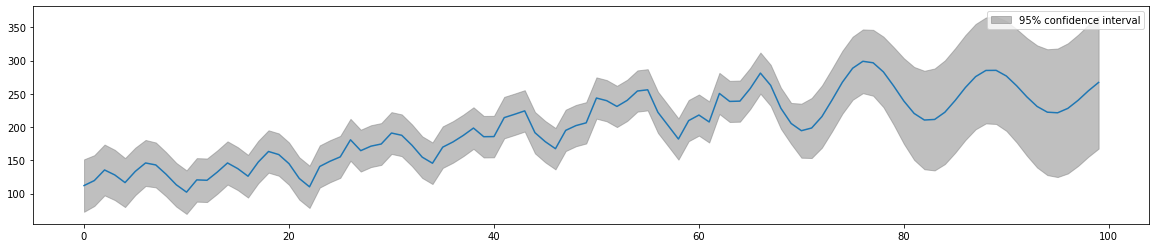

In [33]:
model = sm.tsa.ARIMA(X, order=(2,1,2))
model_fit = model.fit()
forecast=model_fit.forecast(steps=20)[0]
fig, ax = plt.subplots(figsize=(20,4))
a=plot_predict(model_fit,1, 100,ax=ax);

*The above plot is based on ARIMA model with pdq values and forecasted values at 95% confidence level*

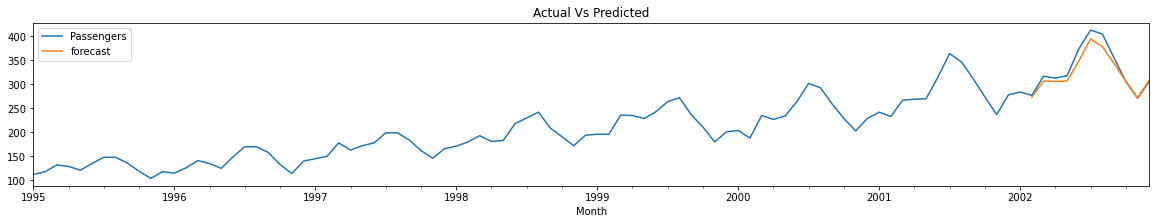

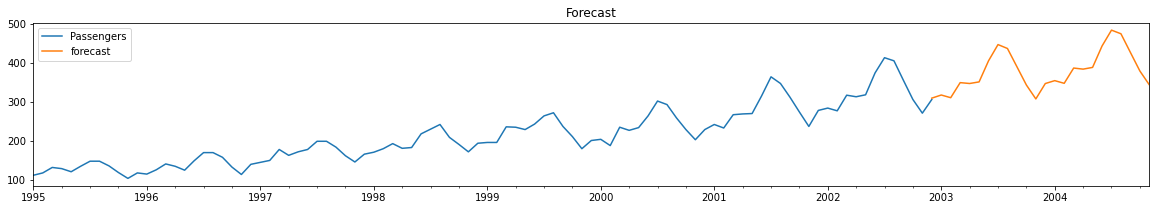

In [34]:
model = sm.tsa.ARIMA(air["Passengers"], order=(2,1,2),seasonal_order=(1,1,1,12))
results=model.fit()
air["forecast"]=results.predict(start=85,end=100,dynamic=True)
air[["Passengers","forecast"]].plot(figsize=(20,3))
plt.title("Actual Vs Predicted")

future_dates=[air.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=air.columns)
future_df=pd.concat([air,future_datest_df])
future_df["forecast"] = results.predict(start = 95, end = 120, dynamic= True)
future_df[["Passengers","forecast"]].plot(figsize=(20, 3))
plt.title("Forecast");

*These 2 plots are build based on ARIMA where pdq and seasonal order are mentioned.The forecasted values shows the orange trend which is almost similar to the previous trend.*

## Model Comparision

In [35]:
data={"Model":pd.Series(["Linear","Exponential","Quadratic","Additive seasonality","Additive Seasonality Quadratic",
                         "Multiplicative Seasonality","Multiplicative Additive Seasonality","Simple Exponential Method",
                         "Holt method","Winter with additive seasonality and trend",
                         "Winter with multiplicative seasonality and additive trend","ARIMA"]),
      "RMSE Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,
                               rmse_Mult_add_sea,rmse_ses,rmse_hw,rmse_hwe_aa,rmse_hwe_ma,rmse_arima])}
RMSE = pd.DataFrame(data)
RMSE.sort_values(["RMSE Values"])

,Model,RMSE Values
6,Multiplicative Additive Seasonality,11.724791
11,ARIMA,22.237036
4,Additive Seasonality Quadratic,30.393043
10,Winter with multiplicative seasonality and add...,34.849070
9,Winter with additive seasonality and trend,42.759252
1,Exponential,43.478471
2,Quadratic,43.898145
0,Linear,48.309856
7,Simple Exponential Method,72.313128
3,Additive seasonality,124.975700


*It can be seen that **Multiplicative Additive Seasonality Model** has the least RMSE value **11.72**.                          So we further continue and make final model based on it.*

In [36]:
#Final Model building On The Entire Dataset 
air_Final = smf.ols("log~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov",data = air1).fit()
pred_air_Final = pd.Series(air_Final.predict(air1))
rmse_air_Final = round(np.sqrt(np.mean((np.array(air1["Passengers"])-np.array(np.exp(pred_air_Final)))**2)),2)
rmse_air_Final

8.93

**The Final Model has a RMSE Value of 8.93**

In [37]:
air_Final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    log   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     396.6
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           6.90e-68
Time:                        15:01:34   Log-Likelihood:                 164.35
No. Observations:                  96   AIC:                            -302.7
Df Residuals:                      83   BIC:                            -269.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6663      0.019    244.427      0.000       4.628       4.704
t              0.0112      0.000     64.390      0.000       0.011       0.012
Jan            0.0154      0.024      0.655      0.514      -0.031       0.062
Feb            0.0147      0.024      0.626      0.533      -0.032       0.062
Mar            0.1467      0.024      6.232      0.000       0.100       0.194
Apr            0.1026      0.024      4.361      0.000       0.056       0.149
May            0.0849      0.024      3.608      0.001       0.038       0.132
Jun            0.1975      0.024      8.400      0.000       0.151       0.244
Jul            0.2925      0.024     12.446      0.000       0.246       0.339
Aug            0.2792      0.023     11.881      0.000       0.232       0.326
Sep            0.1577      0.023      6.713      0.000       0.111       0.204
Oct            0.0164      0.023      0.696      0.488      -0.030       0.063
Nov           -0.1253      0.023     -5.336      0.000      -0.172      -0.079
==============================================================================
Omnibus:                        1.637   Durbin-Watson:                   0.646
Prob(Omnibus):                  0.441   Jarque-Bera (JB):                1.075
Skew:                          -0.141   Prob(JB):                        0.584
Kurtosis:                       3.435   Cond. No.                         699.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
#final model accuracy
print("r2      :   ",round(air_Final.rsquared,2),"\nadj r2  :   ",round(air_Final.rsquared_adj,2),
      "\naic     :",round(air_Final.aic,2))

r2      :    0.98 
adj r2  :    0.98 
aic     : -302.7


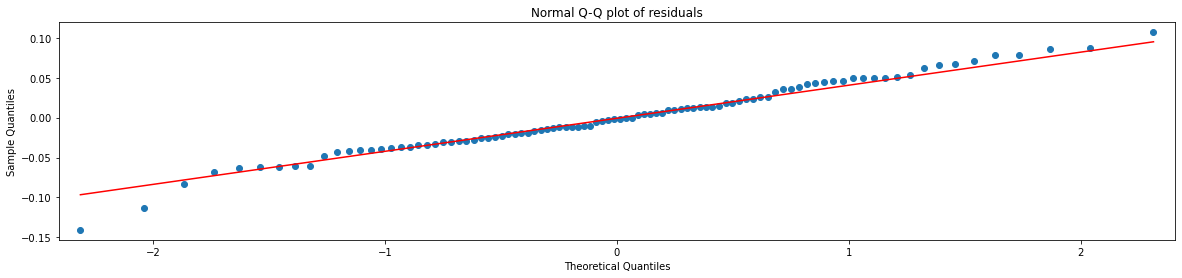

In [39]:
#to plot the errors on line 
fig, ax = plt.subplots(figsize=(20,4))
qqplot=sm.qqplot(air_Final.resid,line="q",ax=ax) 
plt.title("Normal Q-Q plot of residuals")
plt.show();

**The model accuracy and Q-Q Plot shows that the model is good.**